# Wadati Cumulative Diagram Using Seisgram2k Input

In [1]:
## author: Dr. Ade Surya Putra (ITB), dkk.
import pandas as pd
import glob
import numpy as np
from collections import defaultdict
from obspy import UTCDateTime

def is_valid_pick_line(line):
    """
    Validates if a line from the pick file has the expected number of components.
    Expected format:
    [Station, ?, Component, Onset, Phase, Polarity, YearMonthDay, HourMinuteSecond, ArrivalTime]
    """
    return len(line) >= 9

print('Python code for generating catalog picking')

OutputName = "rantaudedap_katalog"
file_name = glob.glob("./picks_2024_11/*.pick")
#file_name = glob.glob("./00_seisgram2k/picks_2024_12//*.pick")

# Modify starting index for Event IDs
start_index = 1  # Change this to set the starting Event ID

df_all = pd.DataFrame(columns=[
    "Event ID", "Station", "Year", "Month", "Day", "Hour", "Minutes_P", "P_Arr_Sec",
    "P_Polarity", "P_Onset", "Minutes_S", "S_Arr_Sec", "S_Polarity", "S_Onset",
    "Ts-Tp", "Minutes_T0", "T0_Sec", "P Travel", "S Travel", "VpVs", "Tp-T0"
])
Index = []
Count = 0

for file_path in file_name:
    Count += 1
    print(f"{Count} | Collecting Event {file_path} ...")
    
    try:
        file_id = event_id = f"{(start_index + Count - 1):04d}" #file_path.split('_')[1].split('\\')[-1] #file_path.split('_')[-1].split('.')[0]
    except IndexError:
        print(f"Error extracting ID from filename: {file_path}")
        continue
    
    dict_holder = defaultdict(list)
    arrival = defaultdict(list)
    split_lines = [line.split() for line in open(file_path, 'r').readlines()]
    for line in split_lines:
        if not is_valid_pick_line(line):
            continue
        
        try:
            if line[5] == "c":
                line[5] = "+"
            elif line[5] == "d":
                line[5] = "-"
            else:
                line[5] = "?"
            if line[3] == "i":
                line[3] = "I"
            elif line[3] == "e":
                line[3] = "E"
            else:
                line[3] = "?"
            if line[2] == 'BHZ' and line[4] == 'P':
                dict_holder[line[0]].extend([
                    line[6][:4], line[6][4:6], line[6][6:], line[7][:2], line[7][2:], float(line[8]),
                    line[5], line[3]
                ])
            elif (line[2] == 'BHN' or line[2] == 'BHE') and line[4] == 'S':
                dict_holder[line[0]].extend([
                    line[7][2:], float(line[8]), line[5], line[3], f"{int(file_id):04d}"
                ])
                Index.append(Count)
        except Exception as e:
            print(f"Error processing line: {line}. Error: {e}")

    try:
        arrival[0] = [dict_holder[v][-1] for v in list(dict_holder.keys())]
        arrival[1] = [v for v in list(dict_holder.keys())]
        for x in range(2, 14):
            arrival[x] = [dict_holder[v][x-2] for v in list(dict_holder.keys())]
    except Exception as e:
        print(f"Error: {e}: Check your pick data, maybe there are some mistakes in the pick's component")
        continue

    ATp_UTC, ATs_UTC = [], []
    try:
        for i in range(len(arrival[5])):
            utc_p = UTCDateTime("{}-{:02d}-{:02d}T{:02d}:{:02d}:{:012.9f}".format(
                int(arrival[2][i]), int(arrival[3][i]), int(arrival[4][i]),
                int(arrival[5][i]), int(arrival[6][i]), float(arrival[7][i])
            ), precision=9)
            utc_s = UTCDateTime("{}-{:02d}-{:02d}T{:02d}:{:02d}:{:012.9f}".format(
                int(arrival[2][i]), int(arrival[3][i]), int(arrival[4][i]),
                int(arrival[5][i]), int(arrival[10][i]), float(arrival[11][i])
            ), precision=9)
            ATp_UTC.append(utc_p)
            ATs_UTC.append(utc_s)
    except Exception as e:
        print(f"Error converting to UTCDateTime: {e}")
        continue

    try:
        for Tp, Ts in zip(ATp_UTC, ATs_UTC):
            TsTp = Ts - Tp
            # Check and adjust Ts if necessary
            if Tp.minute != 0 and Ts.minute == 0:
                TsTp += 3600  # Add 1 hour in seconds
            arrival[14].append(float(TsTp))
    except Exception as e:
        print(f"Error calculating Ts-Tp: {e}")
        continue

    try:
        df = pd.DataFrame.from_dict(arrival)
        df.columns = [
            "Event ID", "Station", "Year", "Month", "Day", "Hour", "Minutes_P", "P_Arr_Sec",
            "P_Polarity", "P_Onset", "Minutes_S", "S_Arr_Sec", "S_Polarity", "S_Onset", "Ts-Tp"
        ]
        df["Event ID"] = df["Event ID"].astype(str).str.zfill(4)
    except Exception as e:
        print(f"Error creating DataFrame: {e}")
        continue

    try:
        Minutes_T0, T0_Sec = [], []
        x = [i.hour * 3600 + i.minute * 60 + i.second + i.microsecond / 1e6 for i in ATp_UTC]
        y = df['Ts-Tp']
        z = np.polyfit(x, y, 1)
        T0 = (-1 * z[1]) / z[0]
        T0 = UTCDateTime(f"{int(ATp_UTC[0].year):04d}-{int(ATp_UTC[0].month):02d}-{int(ATp_UTC[0].day):02d}T{int(T0 // 3600):02d}:{int((T0 % 3600) // 60):02d}:{float(T0 % 60):012.9f}")
    except Exception as e:
        print(f"Error calculating T0: {e}")
        continue

    try:
        VpVs, TTP = [], []
        for i in ATp_UTC:
            Minutes_T0.append(T0.minute)
            T0_Sec.append(T0.second)
            vpvs = 1 + z[0]
            VpVs.append(vpvs)
            TTp = i - T0
            TTP.append(TTp)
        df["Minutes_T0"] = T0.minute
        df["T0_Sec"] = T0.second + (T0.microsecond * 1e-6)
        df["P Travel"] = TTP
        df["S Travel"] = df["Ts-Tp"] + df["P Travel"]
        df["VpVs"] = VpVs
        df["Tp-T0"] = [(Tp - T0) for Tp in ATp_UTC]
        #df_all = pd.concat([df_all, df], ignore_index=True)
        #if not df.empty:
        df_all = pd.concat([df_all, df], ignore_index=True)
        df_all.index = Index
    except Exception as e:
        print(f"Error updating DataFrame: {e}")
        continue

df_all.to_excel(OutputName + '.xlsx')
print('----------- The code has run successfully! --------------')


Python code for generating catalog picking
1 | Collecting Event ./picks_2024_11\20241101 1456 40.pick ...
2 | Collecting Event ./picks_2024_11\20241102 0134 30.pick ...
3 | Collecting Event ./picks_2024_11\20241104 1850 08.pick ...
4 | Collecting Event ./picks_2024_11\20241105 1644 17.pick ...
5 | Collecting Event ./picks_2024_11\20241105 1657 57.pick ...
6 | Collecting Event ./picks_2024_11\20241108 1903 09.pick ...
7 | Collecting Event ./picks_2024_11\20241109 0044 49.pick ...
8 | Collecting Event ./picks_2024_11\20241109 0044 52.pick ...
9 | Collecting Event ./picks_2024_11\20241109 0154 08.pick ...
10 | Collecting Event ./picks_2024_11\20241109 0939 54.pick ...
11 | Collecting Event ./picks_2024_11\20241110 0019 38.pick ...
12 | Collecting Event ./picks_2024_11\20241111 1400 28.pick ...
13 | Collecting Event ./picks_2024_11\20241111 1426 14.pick ...
14 | Collecting Event ./picks_2024_11\20241115 1558 26.pick ...
15 | Collecting Event ./picks_2024_11\20241118 1603 46.pick ...
16 | C

C:\Users\acer\AppData\Local\Temp\ipykernel_12056\1162919326.py:152: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_all = pd.concat([df_all, df], ignore_index=True)


34 | Collecting Event ./picks_2024_11\20241120 1019 30.pick ...
35 | Collecting Event ./picks_2024_11\20241120 1127 23.pick ...
36 | Collecting Event ./picks_2024_11\20241120 1128 20.pick ...
37 | Collecting Event ./picks_2024_11\20241121 1938 29.pick ...
38 | Collecting Event ./picks_2024_11\20241121 1938 34.pick ...
39 | Collecting Event ./picks_2024_11\20241121 2003 58.pick ...
40 | Collecting Event ./picks_2024_11\20241121 2327 02.pick ...
41 | Collecting Event ./picks_2024_11\20241122 0015 27.pick ...
42 | Collecting Event ./picks_2024_11\20241122 0027 43.pick ...
43 | Collecting Event ./picks_2024_11\20241122 0043 32.pick ...
44 | Collecting Event ./picks_2024_11\20241122 0717 44.pick ...
45 | Collecting Event ./picks_2024_11\20241122 0821 11.pick ...
46 | Collecting Event ./picks_2024_11\20241122 1649 54.pick ...
47 | Collecting Event ./picks_2024_11\20241122 1851 22.pick ...
48 | Collecting Event ./picks_2024_11\20241122 1856 37.pick ...
49 | Collecting Event ./picks_2024_11\20

# Plot Wadati Cumulative

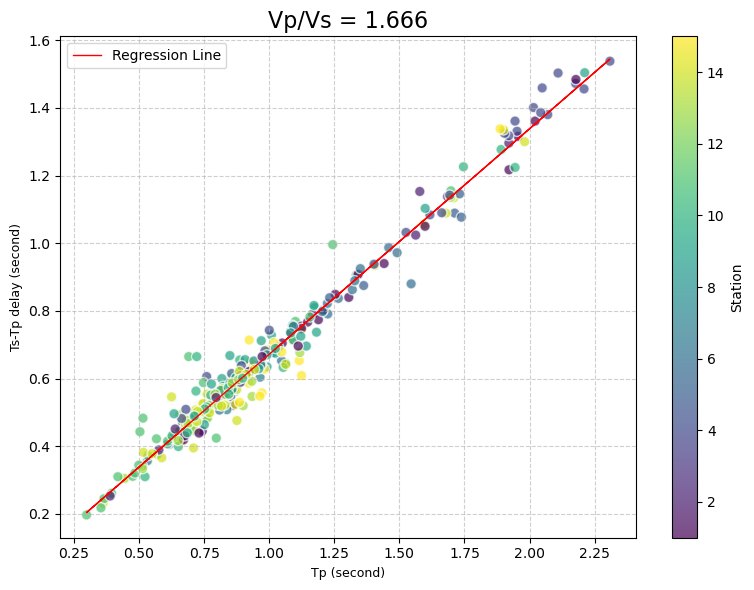

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Define the path to the Excel file
Week_File = rf'{OutputName}.xlsx'

# Read the Excel file
df = pd.read_excel(Week_File)

# Rename the unnamed column to 'No_Event'
df.rename(columns={'Unnamed: 0': 'No_Event'}, inplace=True)

# Encode the 'Station' column to numeric values
# le = LabelEncoder()
# df['Station_encoded'] = le.fit_transform(df['Station'])
df['Station_encoded'] = df['Station'].str.extract(r'RD(\d+)')[0].astype(int)

#df = df[df['P Travel'] < 4]

# Perform linear regression
x = df['Tp-T0']
y = df['Ts-Tp']
slope, intercept = np.polyfit(x, y, 1)
regression_line = slope * x + intercept
xideal = [0, max(x)]
yideal = [intercept, max(x) * 0.73 + intercept]

# Create a scatter plot with matplotlib
plt.figure(figsize=(8, 6))
scatter = plt.scatter(x, y, c=df['Station_encoded'], cmap='viridis', alpha=0.7, edgecolors='w', s=55)
#plt.plot(xideal, yideal, color='k', linewidth=2, linestyle='--', label='Ideal Line', alpha=1)
plt.plot(x, regression_line, color='red', linewidth=1, linestyle='-', label='Regression Line')

# Add colorbar
cbar = plt.colorbar(scatter)
cbar.set_label('Station')

# Add text annotation
#plt.text(min(x) + 10, max(regression_line) - 25, f'Vp/Vs = {1 + slope:.3f}', fontsize=12, ha='left', va='bottom')

# Set plot title and labels
plt.title(f'Vp/Vs = {1 + slope:.3f}', fontsize=16)
plt.xlabel('Tp (second)', fontsize=9)
plt.ylabel('Ts-Tp delay (second)', fontsize=9)

# Add a legend
plt.legend(loc='upper left', fontsize=10, frameon=True)

# Display the plot
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [3]:
df

,No_Event,Event ID,Station,Year,Month,Day,Hour,Minutes_P,P_Arr_Sec,P_Polarity,...,S_Polarity,S_Onset,Ts-Tp,Minutes_T0,T0_Sec,P Travel,S Travel,VpVs,Tp-T0,Station_encoded
0,1,1,RD05,2024,11,1,14,56,40.525,+,...,?,E,0.485,56,39.832471,0.692529,1.177529,1.663795,0.692529,5
1,1,1,RD06,2024,11,1,14,56,40.515,-,...,?,E,0.435,56,39.832471,0.682529,1.117529,1.663795,0.682529,6
2,1,1,RD01,2024,11,1,14,56,41.138,-,...,?,E,0.840,56,39.832471,1.305529,2.145529,1.663795,1.305529,1
3,1,1,RD04,2024,11,1,14,56,41.358,+,...,?,E,1.032,56,39.832471,1.525529,2.557529,1.663795,1.525529,4
4,2,2,RD02,2024,11,2,1,34,30.286,-,...,?,E,0.445,34,29.543266,0.742734,1.187734,1.681621,0.742734,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
309,62,62,RD14,2024,11,28,8,31,20.394,+,...,?,E,0.621,31,19.508605,0.885395,1.506395,1.691278,0.885395,14
310,63,63,RD14,2024,11,30,1,29,56.956,-,...,?,E,0.612,29,56.044306,0.911694,1.523694,1.672538,0.911694,14
311,63,63,RD13,2024,11,30,1,29,56.927,+,...,?,E,0.597,29,56.044306,0.882694,1.479694,1.672538,0.882694,13
312,63,63,RD10,2024,11,30,1,29,56.942,+,...,?,E,0.601,29,56.044306,0.897694,1.498694,1.672538,0.897694,10


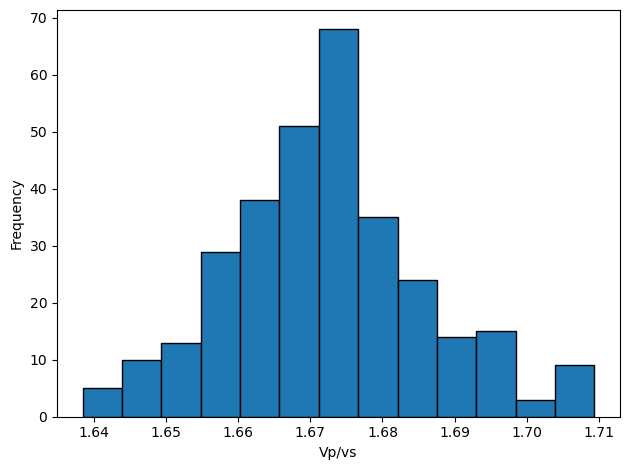

In [4]:
plt.hist(df['VpVs'], bins=13, edgecolor='k')
plt.ylabel("Frequency")
plt.xlabel("Vp/vs")
plt.tight_layout()
plt.show()